# Embedded Methods
## Adaptive-Runge–Kutta


I show here how the Runge–Kutta-Fehlberg method works. I'll implement a general
RKF solver, in which one can give the parameters of *any* stage and order method
and run it. Once I finish understanding it, I'll implement RKF45, and then more!

I found that [thesis](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/6607/pdf/imm6607.pdf)
to be very useful.


The explicit Runge–Kutta (RK) method can be made, efficiently, adaptive. This is done
by the so-called embedded methods, which basically involves the calculation of each step
by two different solvers, and adapting the step-size until their difference is below some acceptable
value. The proceedure is similar to the classical RM methods (one of order $p$ and the other $p+1$).

Lets assume that we have a differential equation
$$
\dfrac{d\vec{y}}{dt}=f(\vec{y},t) \;,
$$
with  given $\vec{y}(0)$ (as always $t \in [0,1]$). We follow the iteration:[$^1$](#1)

$$
\vec{y}_{n+1}=\vec{y}_{n}+ \sum_{i=1}^{s} b_i \vec{k}_i \\
\vec{y}^{\star}_{n+1}=\vec{y}_{n}+ \sum_{i=1}^{s} b_i^{\star} \vec{k}_i \;,
$$
with
$$
\vec{k}_{i}=f\Bigg(\vec{y}_{n}+h \Big(\sum_{j=1}^{i-1}a_{ji}\vec{k}_{i} \Big), t_{n}+h c_{i}   \Bigg)\;.
$$

Having the two estimates for the next step, we can estimate the error 

$$
\epsilon \equiv \left|\vec{y}_{n+1}- \vec{y}^{\star}_{n+1} \right|=
\left| \sum_{i} (b_{i}-b_{i}^{\star}) \vec{k}_{i} \right|\, h \;.
$$

Then, if $\epsilon \geq \epsilon_0$ ($\epsilon_0$ is some desirable error), we adjust the stepsize as[$^2$](#footnote2)

$$ 
h \to \beta h \left (\dfrac{\epsilon_0}{\epsilon} \right)^{1/p} \;,
$$

and calculate again $\vec{y}_{n+1}$ and $\vec{y}_{n+1}^{\star}$ until  $\epsilon < \epsilon_0$.
When $\epsilon < \epsilon_0$, we accept $y_{n+1}$ ($y_{n+1}^{\star}$ is just for stepsize control!),
we increase the stepsize a bit

$$ 
h \to \beta h \left (\dfrac{\epsilon_0}{\epsilon} \right)^{1/(p+1)} \;,
$$

and move to the next step.


$$\begin{array}{}
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
\hline
\end{array}$$ 
<span id="footnote1">$^1$ </span>Butcher tableau in this case is written as

$$
\begin{array}{c|cccc}
0      & 0      &   0   &      0& \dots & 0& 0\\
c_2    & a_{21} &   0   &   0   & \dots & 0& 0\\
c_3    & a_{31} & a_{32}&      0& \dots & 0& 0\\
\vdots & \vdots & \vdots& \vdots&\ddots &\ddots& \vdots\\
c_s    & a_{s1} & a_{s2}& a_{s3}& \dots & a_{s s-1}& 0 \\
\hline
 p      & b_1    & b_2  & b_3 & \dots & b_{s-1} & b_s \\
 p+1      & b_1^{\star}    & b_2^{\star}  & b_3^{\star} & \dots & b_{s-1}^{\star} & b_s^{\star}
\end{array}
$$



<span id="footnote2">$^2$ </span>
Note that $\beta \approx 1$ is an input parameter used to adjust
the aggresiveness of the changes in h.


### RKF Algorithm
In an algorithmic way, the RKF method can be written as:

```bash
Inputs-> system_eqs=dydt, initial_condition=y0, No_equations=Neqs, initial_step_size=h0, 
            minimum_step_size=hmin, maximum_step_size=hmax, maximum_No_steps=Nsteps, 
            relative_tolerance=eps_rel, absolute_tolerance=eps_abs, beta=b, method=RKpq
#Initializations
tn=0

#allocate lists we will need: 
Define k[Neqs][s], ak[Neqs], bk[Neqs], bstark[Neqs], ynext[Neqs], ynext_star[Neqs], yn[Neqs],

#Allow steps and solution to be arrays with maximum number of steps (or use dynamic arrays or something)
Define steps[Nsteps], solution[Neqs][Nsteps] 
        


for eq in [1,2,...,Neq]
    yn[eq]=y0[eq]
    ynext[eq]=0
    ynext_star[eq]=0
    delta[eq]=0

h=h0

while tn<1 and step<Nsteps do
    
    h_stop=True#change to False when you find a suitable h
    while h_stop do
        #calculate \vec{k}
        for stage in [1,2...,s] do
            for eq in [1,2...,Neqs] do
                ak[eq]=sum(a[j,i]*k[i], i in [1,...,stage-1] )
            done

            for eq in [1,2,...,Neq] do
                self.k[eq][stage]=dydt( sum(yn[i] +_ak[i], i in [1,2,...,Neqs]) ,tn+ c[stage]*h)[eq]
            done
        done

        #calculate \vec{y}_{n+1} and \vec{y}_{n+1}_{\star}
        ## first calculate sum b*k         
        for eq in [1,2,...,Neqs]do
            bk[eq]=sum(b[i]*k[eq][i]*h, i in [1,2,...,s])
            bstark[eq]=sum(bstar[i]*k[eq][i]*h, i in [1,2,...,s])
        done


        for eq in [1,2,...,Neqs]do
            ynext[eq]=yn[eq]+ bk[eq]
            ynext_star[eq]=yn[eq]+ bstark[eq]
            delta[eq]=ynext[eq]-ynext_star[eq]
            
        done
        
        #find current error and relative error 
        abs_err_n=abs(delta) #you may take the euclidean abs, or something else.
        
        #calculate relative error
        for eq in [1,2,...,Neqs]do
            rel_delta[eq]=(ynext[eq]-ynext_star[eq])/ynext[eq]
        done
        rel_err_n=abs(rel_delta)
        
        
        #adjust h. There are more refined ways to do this, but this is a start.  
        ##################################################################################################
        if (err_n>eps_abs or rel_err_n> eps_rel) then
            h=beta*h0*(eps_abs/abs_err)^(1/p) #p is given by the method
        else 
            h=beta*h0*(eps_abs/abs_err)^(1/(p+1))
            h_stop=False
        fi
        
        #if you have limits apply them
        if h>hmax then    
            h=hmax
        fi
        
        if h<hmin then
            h=hmin
        fi
        
        h0=h
        ##################################################################################################
    done
    
    
    for eq in [1,2,...,Neqs] do
        yn[eq]=ynext[eq]
        solution[eq][step]=yn[eq]
    done
    
    
    
    
    tn=tn+h
    if tn>1 then
        tn=1
    fi
    
    steps[step]=tn
    
    step=step+1
done

return steps, solution

#note that for error monitoring, it may be useful to return an
#array with the errors and stepsize at each step.
```



For example the RKF45


todo...

In [1]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=10
plt.rcParams['mathtext.fontset']='stixsans'

In [2]:
#define Heun–Euler parameters
class HeunEuler:
    def __init__(self):
        self.s=2
        self.p=1
        self.c=[0,1]
        self.b=[1/2. , 1/2.]
        self.bstar=[1.,0.]
        self.a=[ [0 for j in range(self.s)] for i in range(self.s)]
        self.a[1][0]=1
        
he=HeunEuler()

In [3]:

class RKF:
    
    '''
       This is still exRK, but I will adjust it to RKF
    
    '''
    
    def __init__(self,n_eqs,diffeq,init_cond,RK_method,
                      initial_step_size=1e-2,minimum_step_size=1e-5,maximum_step_size=1e-1,
                      maximum_No_steps=50000,relative_tolerance=1e-4,absolute_tolerance=1e-2,
                      beta=0.5):
        
        
        self.tiny=1e-20#define a tiny number. Below this, errors are ignored..
        
        #get all inputs
        self.dydt=diffeq.dydt
        self.number_of_eqs=n_eqs
        self.h0=initial_step_size
        self.hmin=minimum_step_size
        self.hmax=maximum_step_size
        self.max_N=maximum_No_steps
        self.abs_eps=absolute_tolerance
        self.rel_eps=relative_tolerance
        self.beta=beta
        
        #get the parameters that define the method
        self.s=RK_method.s
        self.p=RK_method.p
        self.a=RK_method.a
        self.b=RK_method.b
        self.bstar=RK_method.bstar
        self.c=RK_method.c
        
        #initialize arrays
        self.steps=[0]*self.max_N #this is faster that using a for 
        self.k=[0 for i in range(self.number_of_eqs)]#this is initiated to hold all ks
        for eq_i in range(self.number_of_eqs):
            self.k[eq_i]=[0 for i in range(self.s)]
        self.solution=[0 for i in range(self.number_of_eqs)]
        for eq_i in range(self.number_of_eqs):
            self.solution[eq_i]=[0 for i in range(self.max_N)]
            
        for eq_i in range(self.number_of_eqs):
            self.solution[eq_i][0]=init_cond[eq_i]#the first step is the initial condition
            
        self.err_n=[[0 for i in range(self.max_N)], [0 for i in range(self.max_N)]]

        #declare arrays and parameters you are going to need
        #self.ak=[0]*self.number_of_eqs
        #self.bk=[0]*self.number_of_eqs
        #self.bstark=[0]*self.number_of_eqs
        self.ynext=[0]*self.number_of_eqs
        self.ynext_star=[0]*self.number_of_eqs
        self.yn=[0]*self.number_of_eqs
        self.abs_delta=[0]*self.number_of_eqs
        self.rel_delta=[0]*self.number_of_eqs
        
        
        #initialize a counter
        self.current_step=0
        
        self.end=False# This will be chang to True when the end is reached
        

        

        
        for eq in range(self.number_of_eqs):
            self.yn[eq]=init_cond[eq]
            self.ynext[eq]=0
            self.ynext_star[eq]=0
            #self.abs_delta[eq]=0
            #self.rel_delta[eq]=0
        
        self.h_stop=False
        self.h=self.h0
        self.tn=0
        
        
    # function to calculate the \sum_{i=1}^{current stage-1} a_{current stage,i} \vec{k}_{i}*step_size
    def sum_ak(self,stage):
        self.ak=[0]*self.number_of_eqs
        
        for eq_i in range(self.number_of_eqs):
            for i in range(stage-1):
               self.ak[eq_i]+=self.a[stage][i]*self.k[eq_i][i]*self.h
        
        
    
    # function to calculate the \sum_{i=1}^{s} b_{i} \vec{k}_{i}*step_size
    def sum_bk(self):
        self.bk=[0]*self.number_of_eqs
        self.bstark=[0]*self.number_of_eqs
        for eq_i in range(self.number_of_eqs):
            for i in range(self.s):
                self.bk[eq_i]+=self.b[i]*self.k[eq_i][i]*self.h
                self.bstark[eq_i]+=self.bstar[i]*self.k[eq_i][i]*self.h

    
    #adjust h. There are more refined ways to do this, but this is a start.  
    def step_control(self):
        _delta=0
        _r_delta=0
        for eq in range(self.number_of_eqs):
            _delta+= self.abs_delta[eq]**2.
            _r_delta+= self.rel_delta[eq]**2.
        _delta=_delta**0.5
        _r_delta=_r_delta**0.5
        
        if _r_delta<self.tiny:
            _r_delta=self.rel_eps
        if _delta<self.tiny:
            _delta=self.abs_eps

        
        if _delta>self.abs_eps or _r_delta>self.rel_eps:
            self.h=self.beta*self.h0*(self.abs_eps/_delta)**(1/(self.p))
        else:
            self.h=self.beta*self.h0*(self.abs_eps/_delta)**(1/(self.p+1))
            self.err_n[0][self.current_step]=_delta
            self.err_n[1][self.current_step]=_r_delta
            self.h_stop=False
            
        if self.h>self.hmax:
            self.h>self.hmax
            
        if self.h<self.hmin:
            self.h>self.hmin
        
        
        self.h0=self.h #h0 is redundant, but use it for clarity
        #print(self.h0,self.h_stop)
                
    def next_step(self):
        '''
        Get the next step.
        '''
        if not (self.tn<1. and self.current_step<self.max_N-1):
            self.end=True 
        else:
            
            while True:
                

                #define a list which holds previous point (makes the code slower, but more transparent) 
                for eq_i in range(self.number_of_eqs):
                    self.yn[eq_i]=self.solution[eq_i][self.current_step]

                #this is \vec{k}_1.  
                for eq_i in range(self.number_of_eqs):
                    self.k[eq_i][0]=self.dydt(self.yn,self.tn)[eq_i]

                #once you have \vec{k}_1, find the others.
                for stage in range(1,self.s):
                    #since \sum_{i=1}^{s} a_{stage,i} \vec{k}_{i}*step_size is the same for all 
                    #equations in a given stage, call here self.sum_ak
                    self.sum_ak(stage)
                    #get a d\vec{y}/dt needed for \vec_{k}_{stage}
                    _tmp_sum=[self.yn[i] + self.ak[i] for i in range(self.number_of_eqs) ]
                    _dydt=self.dydt( _tmp_sum ,self.tn+self.c[stage]*self.h )
                    for eq_i in range(self.number_of_eqs):
                        self.k[eq_i][stage]=_dydt[eq_i]


                #calculate \sum_{i=1}^{s} b_{i} \vec{k}_{i}*step_size
                self.sum_bk()
                #calculate y_{n+1} and y_{n+1}^{\star}
                for eq in range(self.number_of_eqs):
                    self.ynext[eq]=self.yn[eq]+ self.bk[eq]
                    self.ynext_star[eq]=self.yn[eq]+ self.bstark[eq]
                    
                    self.abs_delta[eq]=self.ynext[eq]-self.ynext_star[eq]
                    self.rel_delta[eq]=(self.ynext[eq]-self.ynext_star[eq])/self.ynext[eq]
                
                self.step_control()
                if not self.h_stop:
                    break
            
            for eq in range(self.number_of_eqs):
                    self.yn[eq]=self.ynext[eq]
                    self.solution[eq][self.current_step+1]=self.ynext[eq]
            
            self.tn+=self.h
            if self.tn>1:
                self.tn=1
    
            self.steps[self.current_step]=self.tn
            

            self.current_step+=1
            
        
                
            
    def solve(self):
        '''
        Run  next_step until self.end becomes True.
        '''
        while not self.end:
            self.next_step()
        
        self.t=self.steps[:self.current_step]
        self.deltas=[0,0]
        self.deltas[0]=self.err_n[0][:self.current_step]
        self.deltas[1]=self.err_n[1][:self.current_step]
        self.y=[0 for i in range(self.number_of_eqs)]
        for eq_i in range(self.number_of_eqs):
            self.y[eq_i]=[0 for i in range(self.current_step)]
        
        for eq in range(self.number_of_eqs):
            for step in range(self.current_step):
                self.y[eq][step]=self.solution[eq][step]

        

In [4]:
class diff_eq:
    def __init__(self,n=1):
        self.n_eqs=n
        
        
    def dydt(self,y,t):

        return [-20*y[0]*t**3,
                5*y[0]*t**2+2*(-y[1]**2+y[2]**2)*t**0.5,  
                15*y[0]*t**2+2*(y[1]**2-y[2]**2)*t**0.5 ]

    
dydt=diff_eq(3)

in0=[5,10,0]
sol1=RKF(n_eqs=3,diffeq=dydt,init_cond=in0,RK_method=he,
                      initial_step_size=1e-3,minimum_step_size=1e-5,maximum_step_size=1e-3,
                      maximum_No_steps=20000,relative_tolerance=1e-3,absolute_tolerance=1e-3,
                      beta=0.1 )

In [5]:
%%timeit -n 1 -r 1
sol1.solve()

64 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<IPython.core.display.Javascript object>


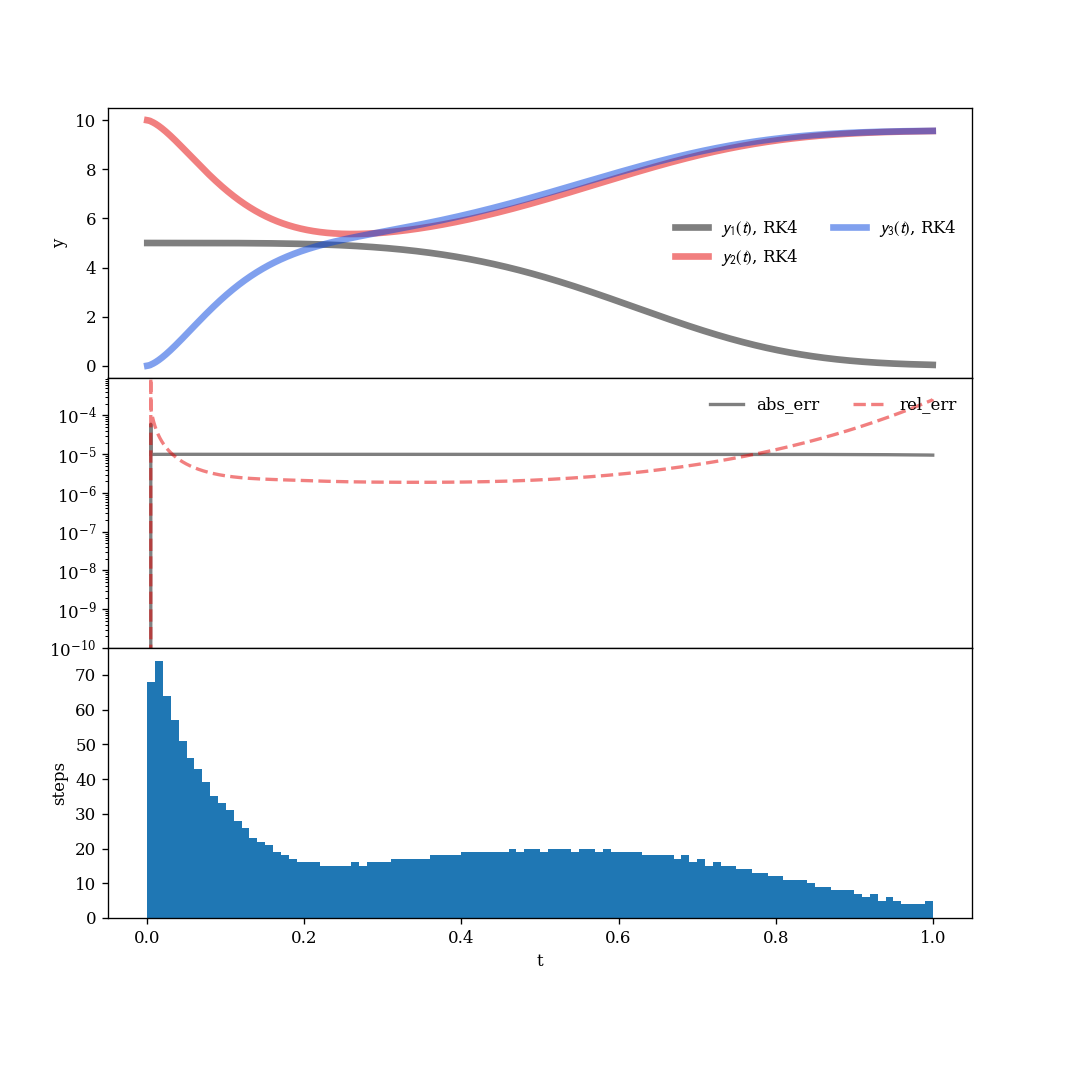

In [6]:
fig=plt.figure(figsize=(9,9))
fig.subplots_adjust(bottom=0.15, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.0)
fig.suptitle('')



_c=['xkcd:black','xkcd:red','xkcd:blue']
sub = fig.add_subplot(311)
for i in range(len(sol1.y)):
    sub.plot(sol1.t,sol1.y[i],c=_c[i],alpha=0.5,linestyle='-',linewidth=4,label=r'$y_{'+str(i+1)+'}(t)$, RK4')    
    sub.set_ylabel('y')  
sub.legend(framealpha=0,ncol=2,loc='center right',bbox_to_anchor=(1,0.5))

sub = fig.add_subplot(312)    
sub.plot(sol1.t,sol1.deltas[0],c=_c[0],alpha=0.5,linestyle='-',linewidth=2,label="abs_err")
sub.plot(sol1.t,sol1.deltas[1],c=_c[1],alpha=0.5,linestyle='--',linewidth=2,label="rel_err")
sub.legend(framealpha=0,ncol=2,loc='center right',bbox_to_anchor=(1,.9))
sub.set_ylim(
    max([min([min(sol1.deltas[0]),min(sol1.deltas[1])]),1e-10]),max([max(sol1.deltas[0]),max(sol1.deltas[1])]) )
sub.set_yscale('log')

sub = fig.add_subplot(313)    
sub.hist(sol1.t,bins=100)
sub.set_ylabel('steps')
    
sub.set_xlabel('t')  


plt.show()